In [1]:
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import numpy as np



In [2]:
dataset_df = pd.read_csv('dataset.csv').to_numpy()
sounds_dataset = dataset_df[:, 0]
sr = 0
sum = 0
for i in range(len(sounds_dataset)):
    sounds_dataset[i], sr = librosa.load(f'Noisy-sounds/{sounds_dataset[i]}.wav')
    sum += len(sounds_dataset[i]) / sr

label_dataset = dataset_df[:, 1]
for i in range(len(label_dataset)):
    label_dataset[i], sr = librosa.load(f'Clean-sounds/{label_dataset[i]}.wav')

X_train, X_test, y_train, y_test = train_test_split(sounds_dataset, label_dataset, test_size=0.1, random_state=42)



In [3]:
print(sum)

16255.142721088108


In [3]:
print(sr)
def to_spectogram(sound):
    stft = librosa.stft(sound.astype(np.float64), n_fft=256, hop_length=128)
    stft = np.abs(stft)
    db = librosa.amplitude_to_db(stft, ref=np.max)
    return np.array(db)


22050


In [4]:
spectogram_train = []
for x in X_train:
    spectogram_train.append(to_spectogram(x))
spectogram_label = []
for x in y_train:
    spectogram_label.append(to_spectogram(x))
spectogram_val = []
for x in X_test:
    spectogram_val.append(to_spectogram(x))
spectogram_val_label = []
for x in y_test:
    spectogram_val_label.append(to_spectogram(x))



In [5]:
X_train = []
y_train = []
X_test = []
y_test = []


In [6]:
def split_to_ms(vector):
    frame_size = 16
    final = []
    for i in range(len(vector)):
        crt = []
        vec = vector[i]
        for col in range(0, len(vec[0]), frame_size):
            for j in range(len(vec)):
                crt.append(vec[j][col:col+frame_size])
            if len(crt[0]) != frame_size:
                for j in range(len(crt)):
                    crt[j] = np.pad(crt[j], ((0, frame_size - len(crt[j]))))
            final.append(np.array(crt))
            break
        break   
    final = np.array(final)
    print(final.shape)
    return final


In [7]:
max_len = 0

#X_train = split_to_ms(spectogram_train)
#y_train = split_to_ms(spectogram_label)
#X_test = split_to_ms(spectogram_val)
#y_test = split_to_ms(spectogram_val_label)

for x in spectogram_train:
    max_len = max(max_len, len(x[0]))
for x in spectogram_label:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val_label:
    max_len = max(max_len, len(x[0]))
print(max_len)
print(len(spectogram_train[0]))

863
129


In [8]:
def pad_vector(vec):
    for i in range(len(vec)):
        vec[i] = np.pad(vec[i], ((0, 0), (0, max_len - len(vec[i][0]))), constant_values=(0, -80))
    return vec

In [9]:
spectogram_train = pad_vector(spectogram_train)
spectogram_label = pad_vector(spectogram_label)
spectogram_val = pad_vector(spectogram_val)
spectogram_val_label = pad_vector(spectogram_val_label)

In [10]:
spectogram_train = np.array(spectogram_train)
spectogram_label = np.array(spectogram_label)
spectogram_val = np.array(spectogram_val)
spectogram_val_label = np.array(spectogram_val_label)

In [11]:
spectogram_train = spectogram_train / -80
spectogram_label = spectogram_label / -80
spectogram_val = spectogram_val / -80
spectogram_val_label = spectogram_val_label / -80

In [ ]:
print(spectogram_train.shape)

In [22]:
print(spectogram_train[0][-1][0])

1.0


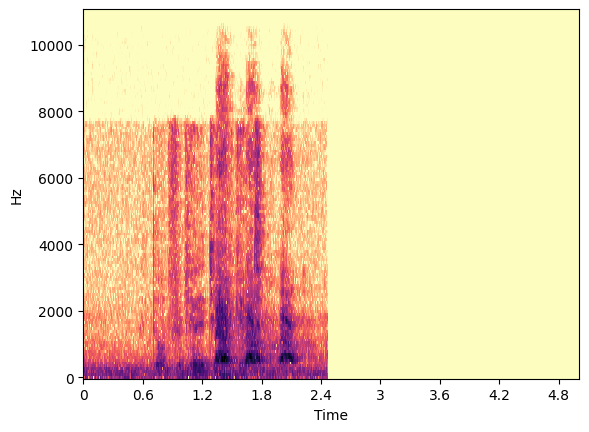

In [14]:
test = spectogram_train[0]
librosa.display.specshow(test, x_axis='time', y_axis='linear', hop_length=128)

In [ ]:
print(np.min(spectogram_train[0]), np.max(spectogram_train[0]))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow import keras
# Define the dimensions of the input data
input_shape = (129, 863, 1)  # MNIST dataset has 28x28 grayscale images

inputs = tf.keras.Input(shape=input_shape)

# Encoder
conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
conv1 = keras.layers.Cropping2D(((0, 1), (0, 7)))(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# Decoder
conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
up1 = keras.layers.UpSampling2D(size=2)(conv4)
up1 = keras.layers.concatenate([conv3, up1], axis=-1)

conv5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
conv5 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
up2 = keras.layers.UpSampling2D(size=(2, 2))(conv5)
up2 = keras.layers.concatenate([conv2, up2], axis=-1)

conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
up3 = keras.layers.UpSampling2D(size=(2, 2))(conv6)
up3 = keras.layers.concatenate([conv1, up3], axis=-1)

# Output layer
outputs = keras.layers.Conv2DTranspose(16, (4, 4), activation='sigmoid')(up3)
outputs = keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid')(outputs)
outputs = keras.layers.Cropping2D(((0, 6), (0, 0)))(outputs)



model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

In [ ]:
history = model.fit(spectogram_train, spectogram_label,
                epochs=10,
                batch_size=16,
                shuffle=True,
                validation_data=(spectogram_val, spectogram_val_label),)

In [ ]:
sample, sr = librosa.load('Noisy-sounds/Sound2709.wav')
sample = to_spectogram(sample)
sample = np.array(sample)
sample = np.pad(sample, ((0, 0), (0, max_len - len(sample[0]))))
sample = np.expand_dims(sample, axis=0)
sample = sample / -80

prediction = model.predict(sample)

import soundfile as sf
import matplotlib.pyplot as plt
prediction = np.squeeze(prediction)
prediction = prediction * -80
prediction = prediction + 3
prediction = librosa.db_to_amplitude(prediction)
prediction = librosa.griffinlim(prediction, hop_length=128, n_fft=256)

sf.write('test_denoised.wav', prediction, sr)

In [ ]:
target, sr = librosa.load('Clean-sounds/1087_MTI_DIS_XX.wav')
target = np.pad(target, (0, len(prediction) - len(target)))
print(np.mean((target - prediction)[:60000]))
target = to_spectogram(target)
librosa.display.specshow(target, y_axis='log', x_axis='time')